In [ ]:
# Plotting a file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

i = 46

filename = f"data/SDS{i:05d}.dat"

# For example, if the .dat file is CSV-like
df = pd.read_csv(filename, delimiter=",", header=None)
d = df.to_numpy()
plt.plot(d[:, 0], d[:, 1])
plt.show()

In [145]:
def compute_power(file_num, tmin=-3e-6, tmax=6e-6):
    filename = f"data/SDS{file_num:05d}.dat"
    try:
        df = pd.read_csv(filename, delimiter=",", header=None)
    except:
        print(f"Problem with file {filename}")
        return np.nan

    d = df.to_numpy()
    t = d[:, 0]
    v = d[:, 1]

    if min(t) > tmin or max(t) < tmax:  # the maxes should be reached
        print(
            f"Problem with file {filename}: min(t) = {min(t)}, max(t) = {max(t)}, tmin = {tmin}, tmax = {tmax}"
        )
        return np.nan

    t_mask = (t > tmin) & (t < tmax)
    t = t[t_mask]
    v = v[t_mask]

    power = np.linalg.norm(v) ** 2
    # power = np.max(v)**2
    return power

In [146]:
compute_power(46)

Problem with file data/SDS00046.dat


nan

In [147]:
# Read the metadata.csv file
metadata = pd.read_csv("metadata.csv")

# Display the first few rows of the metadata
# print(metadata.head())

# You can now use this metadata DataFrame for further analysis or processing
metadata.columns

Index(['Skull Position', 'Index (column, 1-indexed)', 'Index (row, 1-indexed)',
       'Frequency (MHz)', 'SDS Sample #', 'Input Voltage (V)',
       'Peak to Peak (mV)', 'Notes', 'Raffi says bad', 'Unnamed: 9'],
      dtype='object')

In [148]:
# Function to check if a string can be converted to an integer
def is_integer(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

In [149]:
# Create a function to get power for a specific position and skull state
def get_power_for_position(col, row, freq, skull_position):
    row_data = metadata[
        (metadata["Index (column, 1-indexed)"] == col)
        & (metadata["Index (row, 1-indexed)"] == row)
        & (metadata["Skull Position"] == skull_position)
        & (metadata["Frequency (MHz)"] == freq)
    ]

    if row_data.empty:
        return np.nan

    file_num = row_data["SDS Sample #"].values[0]
    if pd.isna(file_num) or not is_integer(file_num):
        return np.nan
    return compute_power(int(file_num))


# Get unique positions
positions = metadata[
    ["Index (column, 1-indexed)", "Index (row, 1-indexed)", "Frequency (MHz)"]
].drop_duplicates()

# Create a list to store results
results = []

# Iterate through positions
for _, position in positions.iterrows():
    col, row, freq = (
        position["Index (column, 1-indexed)"],
        position["Index (row, 1-indexed)"],
        position["Frequency (MHz)"],
    )

    # Get power for skull position 0 and 1
    power_no_skull = get_power_for_position(col, row, freq, 0)
    power_with_skull = get_power_for_position(col, row, freq, 1)

    # Check if the position exists for both skull positions
    if np.isnan(power_no_skull) and np.isnan(power_with_skull):
        print(
            f"Ignoring position (Column: {col}, Row: {row}) as it doesn't exist for either skull position."
        )
    elif np.isnan(power_no_skull):
        print(
            f"Ignoring position (Column: {col}, Row: {row}) as it doesn't exist for skull position 0."
        )
    elif np.isnan(power_with_skull):
        print(
            f"Ignoring position (Column: {col}, Row: {row}) as it doesn't exist for skull position 1."
        )
    else:
        results.append(
            {
                "Column": col,
                "Row": row,
                "Power (No Skull)": power_no_skull,
                "Power (With Skull)": power_with_skull,
                "Frequency (MHz)": freq,
                "Attenuation (dB)": 10 * np.log10(power_no_skull / power_with_skull),
            }
        )

# Create a DataFrame from the results
result_df = pd.DataFrame(results)

# Display the table
print(result_df.to_string(index=False))

# Optionally, you can save this to a CSV file
# result_df.to_csv('power_comparison.csv', index=False)

Problem with file data/SDS00046.dat
Ignoring position (Column: 2.0, Row: 2.0) as it doesn't exist for skull position 0.
Problem with file data/SDS00047.dat
Ignoring position (Column: 2.0, Row: 2.0) as it doesn't exist for skull position 0.
Problem with file data/SDS00048.dat
Ignoring position (Column: 2.0, Row: 2.0) as it doesn't exist for skull position 0.
Ignoring position (Column: 4.0, Row: 2.0) as it doesn't exist for skull position 0.
Problem with file data/SDS00058.dat
Ignoring position (Column: 1.0, Row: 3.0) as it doesn't exist for skull position 0.
Problem with file data/SDS00057.dat
Ignoring position (Column: 1.0, Row: 3.0) as it doesn't exist for skull position 0.
Ignoring position (Column: 3.0, Row: 3.0) as it doesn't exist for skull position 1.
Problem with file data/SDS00071.dat
Ignoring position (Column: 4.0, Row: 3.0) as it doesn't exist for skull position 0.
Problem with file data/SDS00085.dat: min(t) = -1.96e-06, max(t) = 2.6039e-05, tmin = -3e-06, tmax = 6e-06
Ignori

In [150]:
result_df

,Column,Row,Power (No Skull),Power (With Skull),Frequency (MHz),Attenuation (dB)
0,2.0,2.0,0.181881,0.040990,3.0,6.471068
1,2.0,3.0,1.874321,0.117377,0.5,12.032597
2,2.0,3.0,0.987844,0.115829,1.0,9.308729
3,2.0,3.0,3.338544,0.118735,2.0,14.489772
4,2.0,3.0,2.011924,0.068066,3.0,14.706824
5,1.0,3.0,1.605981,0.120550,0.5,11.245748
6,1.0,3.0,0.081085,0.096838,3.0,-0.771094
7,4.0,3.0,0.000627,0.006288,3.0,-10.012852
8,4.0,3.0,0.001790,0.003004,0.5,-2.249419
9,4.0,3.0,0.001736,0.003029,1.0,-2.417464


In [152]:
# ignore the (4,3) data
result_df = result_df[~((result_df["Column"] == 4) & (result_df["Row"] == 3))]

In [154]:
result_df

,Column,Row,Power (No Skull),Power (With Skull),Frequency (MHz),Attenuation (dB)
0,2.0,2.0,0.181881,0.040990,3.0,6.471068
1,2.0,3.0,1.874321,0.117377,0.5,12.032597
2,2.0,3.0,0.987844,0.115829,1.0,9.308729
3,2.0,3.0,3.338544,0.118735,2.0,14.489772
4,2.0,3.0,2.011924,0.068066,3.0,14.706824
5,1.0,3.0,1.605981,0.120550,0.5,11.245748
6,1.0,3.0,0.081085,0.096838,3.0,-0.771094
10,2.0,4.0,0.854547,0.258722,0.5,5.189032
11,2.0,4.0,2.424172,0.518159,2.0,6.701001


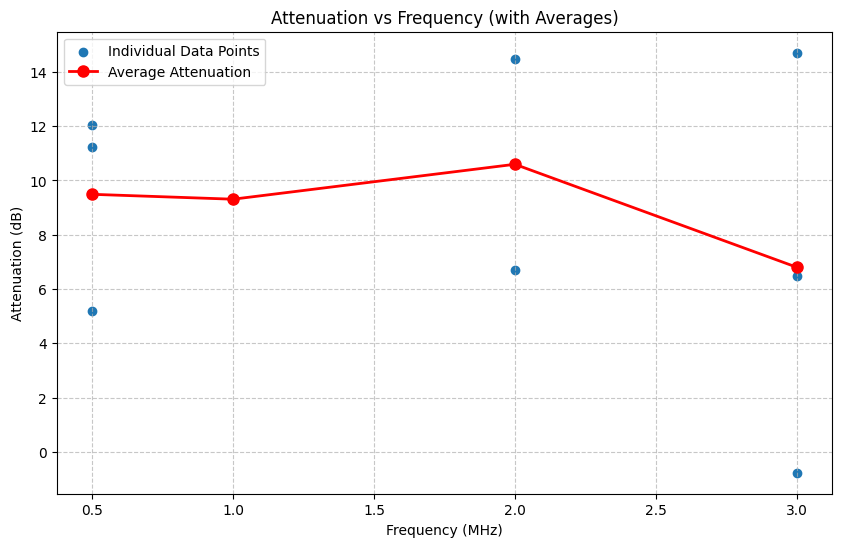

In [153]:
# Create a scatter plot of Attenuation vs Frequency
plt.figure(figsize=(10, 6))
plt.scatter(
    result_df["Frequency (MHz)"],
    result_df["Attenuation (dB)"],
    label="Individual Data Points",
)

# Calculate and plot average attenuation for each frequency
avg_attenuation = result_df.groupby("Frequency (MHz)")["Attenuation (dB)"].mean()
plt.plot(
    avg_attenuation.index,
    avg_attenuation.values,
    "ro-",
    label="Average Attenuation",
    linewidth=2,
    markersize=8,
)

# Set labels and title
plt.xlabel("Frequency (MHz)")
plt.ylabel("Attenuation (dB)")
plt.title("Attenuation vs Frequency (with Averages)")

# Add a grid for better readability
plt.grid(True, linestyle="--", alpha=0.7)

# Add legend
plt.legend()

# Show the plot
plt.show()